### The Practice of Deep Learning 
- **Deep learning models are good at handling high-cardinality categorical features**

Some thoughts to consider:
- Don't underestimate both the constraints and the capabilities of deep learning.
- Don’t spend months fine-tuning a model, polishing the perfect GUI, labeling the dataset. Instead, complete every step as well as you can in a reasonable amount of time, all the way to the end.

### CV Thoughts:
- Deep learning algorithms are generally not good at recognizing images that are significantly different in structure or style from those used to train the model. If some images were missing in trai data, it also perform poorly on test data.
- There is no general way to check which types of images are missing in your training set
- Object detection is slow and expensive (data labeling)
- Data Augmentation is helpful 
- Many non CV tasks might be converted into it (sounds classification)

### NLP Thoughts
- Good at Text Generation (replies to social media)
- Text translation 
- Text Summarization 

### Tabular Data
- In tabular data, **Ensemble algorithms are the kings**(random forest, boosting). DL is usually used as a part of ensemble
- Most of the models for tabular data are trained using CPU. But GPU is also possible (RAPIDS)
- **DL is good for sparse categorical variables and text columns (titles, reviews, ...any text)**

### RecSys
- Sparse tables/matrices (user/products...)
- Collaborative filtering to fill missing values in the sparse matrix
- The main downside - recsys tells **what products a particular user** may like, **rather than what recommendations would be helpful** for a user.

Some recommendations are not helpful - if the user is already familiar with the products, or if they are simply different packagings of products they have already purchased/seen. For example, Jeremy likes reading books by Terry Pratchett, and for a while Amazon was recommending nothing but Terry Pratchett books to him, which really wasn’t helpful because he was already aware of these books! 

### Other Data Types
- Protein Chains, protein analysis (RNN, LSTM, ... NLP models)
- User Journey Prediction (Sequence of actions)
- Sounds Recognition (CNN, ResNet, ... CV Models)

### Drive Train Approach
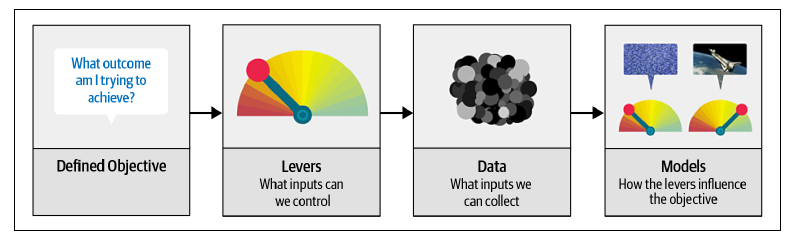

The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

For instance, Google, when creating its first search engine, considered “What is the user’s main objective in typing in a search query?” This led to Google’s objective, which was to “show the most relevant search result.” The next step is to consider what levers you can pull (i.e., what actions you can take) to better achieve that objective. In Google’s case, that was the ranking of the search results. The third step was to consider what new data they would need to produce such a ranking; they realized that the implicit information regarding which pages linked to which other pages could be used for this purpose.

Let’s consider another example: recommendation systems. The objective of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation.

The **lever** is the ranking of the recommendations. **New data** must be collected to generate recommendations that will cause **new sales**

Finally, you could build **two models for purchase probabilities, conditional on seeing or not seeing a recommendation.** The difference between these two probabilities is a **utility function** for a given recommendation to a customer. It will be low in cases where the algorithm recommends a familiar book that the customer has already rejected (both components are small) or a book that they would have bought even without the recommendation (both components are large and cancel each other out).

### Bear Detector 
It will discriminate between three types of bear: 
- grizzly
- black
- teddy bears

Fastai has a tool that allow downloading the data for any objects you’re interested in. 

It downloads the images from `Bing Image Search API` (part of Azure Cognitive Services). It has some rules:
- 1k queries are free, (150 images per queury can be downloaded)

### Data Collection - Bing Image Search 
1. Register a free account and get a key
- `bing_key = 'xxx'` or using cmd 

```
export AZURE_SEARCH_KEY=your_key_here
key = os.environ['AZURE_SEARCH_KEY']
```

2. To search the images use `search_images_bing` function

In [ ]:
from fastai.vision.all import *

In [ ]:
results = search_images_bing(key, 'grizzly bear')
urls = results.attrgot('content_url')
len(urls)

It downloads 150 URLs of bears, to download the images use 

In [ ]:
dest_path = 'images/grizzly.jpg'
download_url(urls[0], dest_path)

img = Image.open(dest_path)
img.to_thumb(128,128)

In [ ]:
# Download images from all URLs
bear_types = 'grizzly','black','teddy' # classes we need
path = Path('bears') # create new dir called bears
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest_path = (path/o) # create new a dir per class
        dest_path.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear') # provide auth key and class name, returns 150 urls 
        download_images(dest_path, urls=results.attrgot('content_url'))

In [ ]:
# Check the files in the dir 
fns = get_image_files(path)
fns

In [ ]:
# Check if we have any failed downloads 
failed = verify_images(fns)
failed

In [ ]:
# To remove all the failed images, you can use unlink
failed.map(Path.unlink);

Now that we have downloaded some data, we need to assemble it in a format suitable for model training.

In fastai, that means **creating an object called `DataLoaders`**

### DataLoaders and DataBlock

To turn our downloaded data into a `DataLoaders` object, we need to tell fastai at least four things:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

To do this, we have to use `Data Block API`, where you can fully **customize every stage** of the creation of your `DataLoaders`. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

- Independent Variable: a set of images
- Dependent Variable: Categories/Classes of bear in our case
- Some datasets already have the data splitted (train/validation in different folders, csv file - mappling: file_name - train/val set)
- All images must have the same format, **use resize**

`DataLoaders` above **includes validation and training `DataLoaders`**. 

`DataLoaders` is a class that provides batches of a few items at a time to the GPU. Default batch size - 64

### Resize Problems 
By default, Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in **losing some important details.** Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**Problems**
- Unrealistic shapes
- Model learns things that look different from how they actually are (low generalization)

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**Problems**
- Have a lot of empty space, wasted computation

### Solution 
What we normally do in practice is to **randomly select part of the image and then crop to just that part.** On each epoch we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

The most important parameter to pass in is `min_scale`, which determines how much of the image to select each time. 

`RandomResizedCrop` is a specific example of **data augmentation.**

### Data Augmentation
Refers to creating random variations of our input data, such that they appear different but do not change the meaning of the data. Examples of common
data augmentation techniques for images are:
- rotation, flipping, perspective warping, brightness/contrast changes

- **Augmentation is applied to the entire batch**

### Model Training 
We don’t have a lot of data for our problem (150 pictures of each sort of beart), so to train the model, we’ll use `RandomResizedCrop`, an image size of 224 pixels, which is fairly standard for image classification, and the default `aug_transforms`

In [ ]:
# Model quality check 
interp = ClassificationInterpretation.from_learner(resnet_model)
interp.plot_confusion_matrix()

It’s helpful to see where exactly our errors are occurring, to see whether they’re due to a dataset problem (e.g., images that aren’t bears at all, or are labeled incorrectly) or a model problem (perhaps it isn’t handling images taken with unusual lighting, or from a different angle, etc.). 

To do this, we can **sort our images by their loss.**

The loss is a number that is higher if the model is incorrect (especially if it’s also confident of its incorrect answer), or if it’s correct but not confident of its correct answer.

### Plot Top Losses
The function shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four
things:
- prediction, actual (target label), loss, and probability (model confidence)

This output shows that the image with the highest loss is one that has been predicted as “grizzly” with high confidence. However, it’s labeled (based on our Bing image search) as “black.” We’re not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to “grizzly.”

The intuitive approach **to doing data cleaning** is to do it **before you train a model.** But as you’ve seen in this case, a **model can help you find data issues more quickly and easily.** So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

Fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that
allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

`ImageClassifierCleaner` **doesn’t do the deleting or changing of labels for you**; it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected for deletion, we must run

To move images for which we’ve selected a different category, we would run this:

### No Need for Big Data
After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we’re using here. As you can see, the common complaint that you need massive amounts of data to do deep learning can be a very long way from the truth!

### Model Deployment 
Once you’ve got a model you’re happy with, you need to save it so you can then copy it over to a server where you’ll use it in production. Model consists of two parts:
- architecture
- trained parameters

We usually save both!!! 

**Model Loading**
When we use a model for getting predictions, instead of training, we call it `inference`

**Do we need a GPU to use that model in production?**
You almost certainly do not need a GPU to serve your model in production. There are a few reasons for this:
- GPUs are useful only when they do lots of identical work in parallel. If you’re doing (say) image classification, you’ll normally be classifying just one user’s image at a time
- CPU is cheap

**Where can I hose my models for free?**
- Binder


### How to Avoid Disaster
Always take into account the following questions:
- Should we regularly remove old data?
- How do we label the data?
- How do we monitor the model performance
- Do we have **out-of-domain data** (data in production is different from training data)
- Do we have **domain-shift** (data that models sees changes over time )